# Stanta Images Classification

## 1. Load Data

In [72]:
# Imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import utilities
import os
import time

# import data visualization
import matplotlib.pyplot as plt

# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
from torch.utils.data import SubsetRandomSampler

from glob import glob
from PIL import Image
from collections import OrderedDict

In [73]:
# define image folders
IMAGE_FOLDER = './images/images/'
SANTA_FOLDER = './images/images/santa/'
NO_SANTA_FOLDER = './images/images/not_santa/'

In [74]:
santa_fns = sorted(glob(SANTA_FOLDER + '*.jpg'))
not_santa_fns = sorted(glob(NO_SANTA_FOLDER + '*.jpg'))

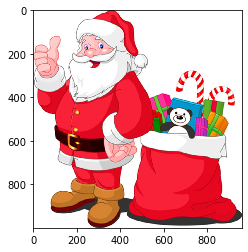

In [75]:
# plot santa image example
santa_img = Image.open(santa_fns[5])
plt.imshow(santa_img)

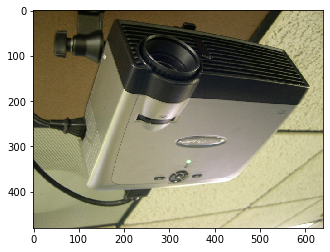

In [76]:
# plot non-santa image example
not_santa_img = Image.open(not_santa_fns[5])
plt.imshow(not_santa_img)

## 2. Create DataLoaders

In [122]:
class SantaDataset(Dataset):
    """Santa images classification dataset."""

    def __init__(self, santa_dir, not_santa_dir, transform=None):
        """
        Args:
            santa_dir (string): Directory with santa images.
            not_santa_dir (string): Directory with non-santa images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.santa_dir = santa_dir
        self.not_santa_dir = not_santa_dir
        self.transform = transform
        self.santa_fns = train_fns = sorted(glob(SANTA_FOLDER + '*.jpg'))
        self.not_santa_fns = sorted(glob(NO_SANTA_FOLDER + '*.jpg'))
        self.length = len(self.santa_fns) + len(self.not_santa_fns)

    def __len__(self):
        return len(self.length)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if idx < len(self.santa_fns):
            image = Image.open(self.santa_fns[idx])
            label = 1
        else:
            image = Image.open(self.not_santa_fns[idx - len(self.santa_fns)])
            label = 0

        if self.transform:
            # convert to RGB
            image = image.convert('RGB')
            # apply transform
            image = self.transform(image)
        else:
            # just convert the image to tensor
            image = TF.to_tensor(image)
            
        #print(image.size())

        return image, label

In [131]:
test_split = 0.2
batch_size = 32
epochs = 10
learning_rate = 0.001
num_workers = 0

In [124]:
transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

dataset = SantaDataset(SANTA_FOLDER, NO_SANTA_FOLDER, transform = transform)

dataset_size = len(santa_fns) + len(not_santa_fns)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
testloader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)

## 3. Setup Hyperparameters and Training

In [125]:
# setup training device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [126]:
model = models.densenet121(pretrained=True)

In [127]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2))
                          ]))
    
model.classifier = classifier

In [128]:
# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = Adam(model.parameters(), lr=learning_rate)

In [129]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy'
                                      ,'Test loss', 'Test accuracy']) 

## 4. Training Loop

In [132]:
#train the model
model.to(device)

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. ")

    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader),
                                      'Train accuracy': train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader),
                                      'Test accuracy': test_accuracy/len(testloader)}, ignore_index=True)

    running_loss = 0
    model.train()

Epoch 1/10.. Time per epoch: 14.9758.. Average time per step: 0.6240.. Train loss: 0.1746.. Train accuracy: 0.9362.. Test loss: 0.5223.. Test accuracy: 0.8090.. 
Epoch 2/10.. Time per epoch: 14.9924.. Average time per step: 0.6247.. Train loss: 0.2479.. Train accuracy: 0.8854.. Test loss: 0.8198.. Test accuracy: 0.8733.. 
Epoch 3/10.. Time per epoch: 14.9700.. Average time per step: 0.6237.. Train loss: 0.2236.. Train accuracy: 0.9076.. Test loss: 0.3490.. Test accuracy: 0.9340.. 
Epoch 4/10.. Time per epoch: 14.9307.. Average time per step: 0.6221.. Train loss: 0.1382.. Train accuracy: 0.9518.. Test loss: 0.3629.. Test accuracy: 0.9097.. 
Epoch 5/10.. Time per epoch: 14.9299.. Average time per step: 0.6221.. Train loss: 0.1014.. Train accuracy: 0.9701.. Test loss: 0.3451.. Test accuracy: 0.9080.. 
Epoch 6/10.. Time per epoch: 14.8801.. Average time per step: 0.6200.. Train loss: 0.1285.. Train accuracy: 0.9648.. Test loss: 0.1668.. Test accuracy: 0.9497.. 
Epoch 7/10.. Time per epoch:

## 5. Analyze Training Statistics

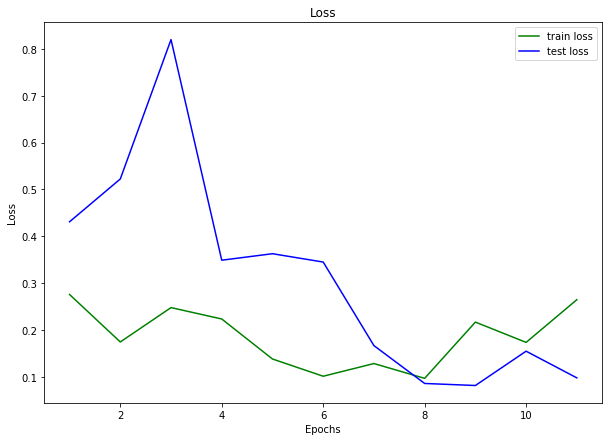

In [140]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss");

x = range(1, len(train_stats['Train loss'].values) + 1)
ax.plot(x, train_stats['Train loss'].values, '-g', label='train loss');
ax.plot(x, train_stats['Test loss'].values, '-b', label='test loss');

plt.legend()
plt.show()

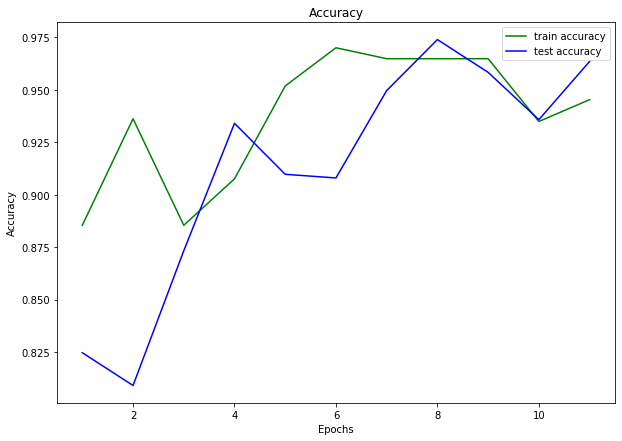

In [139]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

x = range(1, len(train_stats['Train accuracy'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-g', label='train accuracy');
ax.plot(x, train_stats['Test accuracy'].values, '-b', label='test accuracy');

plt.legend()
plt.show()

## 6. View Classification Results

In [137]:
def view_classify(img, ps, title):
    """
    Function for viewing an image and it's predicted classes
    with matplotlib.

    INPUT:
        img - (tensor) image file
        ps - (tensor) predicted probabilities for each class
        title - (str) string with true label
    """
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    image = img.permute(1, 2, 0)
    ax1.imshow(image.numpy())
    ax1.axis('off')
    ax2.barh(np.arange(2), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    ax2.set_yticklabels(list(classes_dict.values()), size='small');
    ax2.set_title(title)
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    plt.show()

In [141]:
classes_dict = {
    0:'not santa',
    1:'santa'
}

for batch_idx, (inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classify(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), classes_dict[int(label_true.cpu().numpy())])
    
    break;

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.00 GiB total capacity; 5.94 GiB already allocated; 0 bytes free; 273.16 MiB cached)